In [1]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


In [2]:
# Helper function to locate full path of file with file_id
files_lookup = {}
for files in glob.glob("./csv/*.csv"):
    files_lookup[files.split("_")[2]] = files
print("example")
files_lookup["819087"]

example


'./csv/File_ID_819087_Index_33564154.csv'

In [3]:
#Files to be loaded
driverDemo =  pd.read_excel("InSight Tables_Keys/DriverDemographic.xlsx")
tripsum =  pd.read_excel("InSight Tables_Keys/TripSummaryMeasures.xlsx")
event =  pd.read_excel("InSight Tables_Keys/eventDetails.xlsx")
eventUpdate = pd.read_excel("InSight Tables_Keys/eventDetailsUpdate.xlsx")
event.head()


def getCrashStatus(ids):
    crash_status = event[event.displayTripId==ids].eventSeverity1.values[0]
    return crash_status


In [4]:
print("Near Crash: ", len(event[event.eventSeverity1 == "Near-Crash"]))
print("Crash: ", len(event[event.eventSeverity1 == "Crash"]))

Near Crash:  296
Crash:  81


In [5]:
def get_age(id):
    # Function to print the age of person
    a = tripsum[tripsum["displayTripID"] == id]['anonymousParticipantID']
    a_string = driverDemo[driverDemo["anonymousParticipantID"] == a.values[0]].ageGroup.values[0]
    a_string = a_string.split("-")
    return int(max(a_string))
print("Age of the person is: ", get_age(14767568))

Age of the person is:  49


In [6]:
def getEventUpdate(tripid):
    preIncedent = eventUpdate[eventUpdate.displayTripId == tripid]['preIncidentManeuver'].values[0]
    maneuver  = eventUpdate[eventUpdate.displayTripId == tripid]['maneuverJudgment'].values[0]
    precipiting = eventUpdate[eventUpdate.displayTripId == tripid]['precipitatingEvent'].values[0]
    return preIncedent, maneuver, precipiting

# Examples
print(getEventUpdate(4952738))

('Starting in traffic lane', 'Safe and legal', 'Other vehicle ahead - slowed and stopped 2 seconds or less')


In [7]:
coded_files = pd.read_excel("SHRP2 Data Recording_File_download_from_Qualtric_May4_2018.xlsx", header = 0)

#Droping the unneccessary columns
coded_files = coded_files.drop(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Scorer', 'Scorer - Topics',  'comment'], axis = 1)


In [8]:
print(coded_files.shape[0])
# Removing the initial test values
coded_files = coded_files[8:]


871


In [ ]:

# printing the number of crashes
print("Number of crashes: ",coded_files[coded_files.crash == 2].shape)

# Not Selecting incomplete videos
coded_files = coded_files[(coded_files["incomplete_video"] != 2)]
coded_files.shape

In [ ]:
# Few new column added
coded_files["Avg_Acceleration"]  = None
coded_files["std_Acceleration"]  = None
coded_files["Avg_speed"]  = None
coded_files["std_speed"]  = None
coded_files["max_speed"] = None
coded_files["max_acceleration"] = None


coded_files["6_Avg_Acceleration"]  = None
coded_files["6_std_Acceleration"]  = None
coded_files["6_Avg_speed"]  = None
coded_files["6_std_speed"]  = None

coded_files["age"] = None

coded_files["crashStatus"] = None

# addding data from eventDetailsupdate
coded_files['preIncidentManeuver'] = None
coded_files['maneuverJudgment'] = None
coded_files['precipitatingEvent'] = None

#coded_files["gender"] = None

In [ ]:
from tqdm import tqdm
not_found = []
for files in tqdm(coded_files.File_id):
    # Reading time 
    time_enter = coded_files[coded_files.File_id==files]["time_of_entering"]
    time_leave = coded_files[coded_files.File_id==files]["time_of_exiting"]

    # Reading files
    try:
        current_vehicle_data = pd.read_csv(files_lookup[str(files)])
    except:
        not_found.append(files)
        continue
    coded_files["crashStatus"][coded_files.File_id==files] = getCrashStatus(files)
    coded_files["age"][coded_files.File_id==files] = get_age(files)
    
    preIncedent, maneuver, precipiting = getEventUpdate(int(files))
    
    coded_files['preIncidentManeuver'][coded_files.File_id==files] = preIncedent
    coded_files['maneuverJudgment'][coded_files.File_id==files] = maneuver
    coded_files['precipitatingEvent'][coded_files.File_id==files] = precipiting
    # Will update only if the time is not nan or other faulty file
    if not (time_enter.isnull().values[0]) and (files != 16990196) and (files != 16990196):
        # Converting the time to int
        
        time_enter = int(time_enter.values[0])
        time_leave = int(time_leave.values[0])
        
        # Average and std in the intersection
        average_curr_vech_data = current_vehicle_data[(current_vehicle_data['vtti.timestamp'] >= time_enter) & (current_vehicle_data['vtti.timestamp'] <= time_leave)].mean()
        std_curr_vech_data = current_vehicle_data[(current_vehicle_data['vtti.timestamp'] >= time_enter) & (current_vehicle_data['vtti.timestamp'] <= time_leave)].std()
        
        # Max of speed and acceleration
        max_curr_vech_data = current_vehicle_data[(current_vehicle_data['vtti.timestamp'] >= time_enter) & (current_vehicle_data['vtti.timestamp'] <= time_leave)].max()
        
        coded_files["Avg_Acceleration"][coded_files.File_id==files] = abs(average_curr_vech_data["vtti.accel_x"])
        coded_files["std_Acceleration"][coded_files.File_id==files] = abs(std_curr_vech_data["vtti.accel_x"])
        coded_files["Avg_speed"][coded_files.File_id==files] = average_curr_vech_data["vtti.speed_network"]
        coded_files["std_speed"][coded_files.File_id==files] = std_curr_vech_data["vtti.speed_network"]

        coded_files["max_speed"][coded_files.File_id==files] =  max_curr_vech_data["vtti.speed_network"]
        coded_files["max_acceleration"][coded_files.File_id==files] =  max_curr_vech_data["vtti.accel_x"]
        
        # Average and std 6 second before the intersection and all the way to the end
        larger_average_curr_vech_data = current_vehicle_data[(current_vehicle_data['vtti.timestamp'] >=(time_enter - 6000)) & (current_vehicle_data['vtti.timestamp'] <= time_leave)].mean()
        larger_std_curr_vech_data = current_vehicle_data[(current_vehicle_data['vtti.timestamp'] >=(time_enter - 6000)) & (current_vehicle_data['vtti.timestamp'] <= time_leave)].std()
        
        coded_files["6_Avg_Acceleration"][coded_files.File_id==files] = abs(larger_average_curr_vech_data["vtti.accel_x"])
        coded_files["6_std_Acceleration"][coded_files.File_id==files] = abs(larger_std_curr_vech_data["vtti.accel_x"])
        coded_files["6_Avg_speed"][coded_files.File_id==files] = larger_average_curr_vech_data["vtti.speed_network"]
        coded_files["6_std_speed"][coded_files.File_id==files] = larger_std_curr_vech_data["vtti.speed_network"]
        
        

In [ ]:
not_found

In [ ]:
coded_files.columns

In [ ]:
leftTurn = coded_files[coded_files.vehicle_movement==2]

In [ ]:
leftTurn.shape

In [ ]:
leftTurn.to_excel("leftturn.xlsx")

In [53]:
leftTurn = pd.read_excel("leftturn.xlsx")

In [54]:
leftTurn.head(5)

,File_id,Time_day,weather_conditions,intersection_type,Dedicated_turn,Wait_at_intersection,signalized_intersect,opposing_lanes,vehicle_movement,Signal_obscured,...,max_acceleration,6_Avg_Acceleration,6_std_Acceleration,6_Avg_speed,6_std_speed,age,crashStatus,preIncidentManeuver,maneuverJudgment,precipitatingEvent
8,61469021,2,1.0,1.0,2.0,2,2,1,2,1.0,...,0.1595,0.100008,0.057583,15.769231,9.137813,34,Near-Crash,Negotiating a curve,Safe and legal,Other vehicle entering intersection - left tur...
9,61724116,2,1.0,2.0,2.0,1,2,2,2,1.0,...,0.0812,0.014693,0.053582,39.936923,1.570693,44,Balanced-Sample Baseline,Decelerating in traffic lane,Safe and legal,(null)
10,61823600,2,2.0,2.0,1.0,2,2,2,2,1.0,...,0.1537,0.012607,0.079653,10.952515,7.927092,34,Near-Crash,Turning left,Unsafe but legal,This vehicle lost control - excessive speed
15,62537802,2,1.0,1.0,1.0,1,2,2,2,1.0,...,-0.0087,0.089578,0.055144,37.314615,9.842376,79,Balanced-Sample Baseline,Turning right,Safe and legal,(null)
16,62572754,2,1.0,2.0,2.0,2,2,2,2,1.0,...,0.2668,0.054206,0.080610,10.640001,11.261587,84,Balanced-Sample Baseline,Decelerating in traffic lane,Safe and legal,(null)


In [55]:
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement", 'intersection_type'], axis = 1)

In [56]:
data.columns

Index(['Time_day', 'weather_conditions', 'Dedicated_turn',
       'Wait_at_intersection', 'signalized_intersect', 'opposing_lanes',
       'Signal_obscured', 'signal_state', 'turn_signal', 'turn_phase',
       'traffic_obscured', 'gap_decision', 'lead_vehicle', 'Avg_Acceleration',
       'std_Acceleration', 'Avg_speed', 'std_speed', 'max_speed',
       'max_acceleration', '6_Avg_Acceleration', '6_std_Acceleration',
       '6_Avg_speed', '6_std_speed', 'age', 'crashStatus'],
      dtype='object')

#  

# Helper Function to fit to the classifier, print training and validation accuracy, precision, recall, f1 Score, Confusion Matrix.

#  

In [57]:
y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)

Number of crashs events:  140.0
Class Balance with Crash and no Crash:  0.509090909091


In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, title="Prediction confusion matrix"):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    pca = PCA(n_components=2)
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    X = filledData_lower
    y = filledData_lower["labels"]
    y  = np.asarray(y,dtype=np.float64)
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    plt.plot(crash[0], crash[1], "*", label=target_names[0])
    plt.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

# Predicting Crash risk of all the drivers using oridinary least square penality considering crash and near crash as one entry.

In [59]:
clf = LogisticRegression(max_iter=1000, penalty='l1')

Training Accuracy Score:  0.71875
validation Accuracy Score: 0.698795180723
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.63      0.75      0.68        36
      Crash       0.78      0.66      0.71        47

avg / total       0.71      0.70      0.70        83

Confusion matrix, without normalization
[[27  9]
 [16 31]]


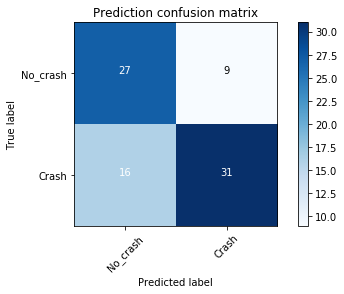

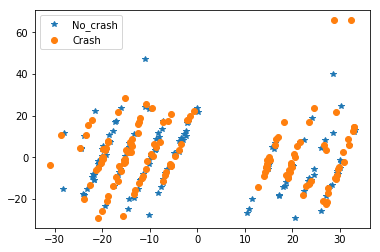

In [61]:
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [18]:
import statsmodels.api as sm
from scipy import stats
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     19.10
Date:                Wed, 23 May 2018   Prob (F-statistic):           1.03e-43
Time:                        22:20:55   Log-Likelihood:                -154.52
No. Observations:                 275   AIC:                             357.0
Df Residuals:                     251   BIC:                             443.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.1879 

#  

# Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.


In [105]:
leftTurn = pd.read_excel("leftturn.xlsx")
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash']
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)

Number of crashs events:  35.0
Class Balance with Crash and Baseline Condition:  0.205882352941


In [106]:
clf = LogisticRegression(max_iter=100, penalty='l1')

Training Accuracy Score:  0.762711864407
validation Accuracy Score: 0.865384615385
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.88      0.98      0.93        45
      Crash       0.50      0.14      0.22         7

avg / total       0.83      0.87      0.83        52

Confusion matrix, without normalization
[[44  1]
 [ 6  1]]


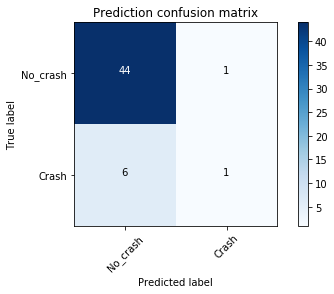

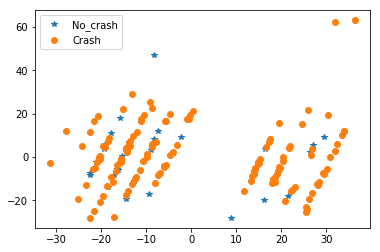

In [107]:
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

#  

In [108]:
import statsmodels.api as sm
from scipy import stats
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     5.936
Date:                Wed, 23 May 2018   Prob (F-statistic):           2.40e-12
Time:                        22:45:20   Log-Likelihood:                -49.000
No. Observations:                 170   AIC:                             146.0
Df Residuals:                     146   BIC:                             221.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.2311 

#  

# Predicting if the driver is young or old from their driving data all 275 data used

In [110]:
# leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus"], axis = 1)

filledData = data.where(pd.notna(data), data.mean(), axis='columns')
y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)

In [111]:
filledData = filledData.drop(["age"], axis =1)

In [112]:
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))

Number of old drivers:  105.0
Class Balance with old drivers and young driver:  0.617647058824


In [113]:
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k="all").fit(filledData,y)
# featurefilledData = selector.transform(filledData)
#featurefilledData.shape

In [114]:
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)

In [115]:
clf = LogisticRegression(max_iter=1000, penalty='l1')

Training Accuracy Score:  0.686440677966
validation Accuracy Score: 0.596153846154
Classification Report: 
             precision    recall  f1-score   support

      Young       0.46      0.30      0.36        20
        Old       0.64      0.78      0.70        32

avg / total       0.57      0.60      0.57        52

Confusion matrix, without normalization
[[ 6 14]
 [ 7 25]]


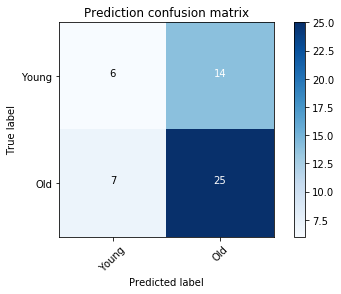

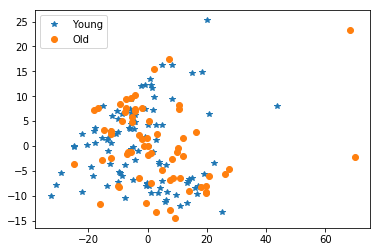

In [116]:
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [103]:
import statsmodels.api as sm
from scipy import stats
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     21.83
Date:                Wed, 23 May 2018   Prob (F-statistic):           2.29e-47
Time:                        22:45:03   Log-Likelihood:                -174.96
No. Observations:                 275   AIC:                             395.9
Df Residuals:                     252   BIC:                             479.1
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                 0.0314 